# Rockall Trough transport

In [2]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.features.matfile_functions as matlab_fct
import src.features.RT_EOF_functions as rt_eof
import src.set_paths as sps
import src.RT_parameters as rtp
import src.features.RT_visualise as rtv

In [3]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
%matplotlib inline
from matplotlib import pyplot as plt

### Set in- and output path

In [50]:
# output
date_str_start = '201407'
date_str_end = '202207'
fn_version = 'v1'
script_name = '9.0_Paper_Rockall_Trough_Results'

# output figures
fig_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/figures/{script_name}/"
fig_out_path_od = Path("C:/Users/sa07kb/OneDrive - SAMS/RT_tansports_2014_2022/figures/")
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [5]:
# file names
RT_mooring_fn = f'Rockall_Trough_mooring_gridded_TSUV_{date_str_start}_{date_str_end}_{fn_version}.nc'
fn_base_stack = "Rockall_Trough_mooring_stacked_TSUV"
file_name_in_stack = f"{fn_base_stack}_{date_str_start}_{date_str_end}_{fn_version}.nc"

## Load Data and prepare for calculations

In [6]:
# Load Rockall Trough mooring location
ds_cruises = rtd.load_cruise_list()

# Rockall Trough mooring location
ds_RT_loc=rtd.load_RT_loc()

# stacked RT mooing data
ds_RT_stacked = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_stack))

# load gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((sps.RT_mooring_data_path/RT_mooring_fn))

# Extrapolate top and linearly interpolate over gaps
ds_RT = rtf.prep_mooring_data_for_transport_calc(ds_RT,ds_RT_loc)

In [7]:
# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((sps.GEBCO_data_path/sps.GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS = rtd.load_glorys('RTADCP',ds_RT.TIME.min(),ds_RT.TIME.max())

# load ERA5
ds_ERA5 = xr.open_dataset((sps.ERA5_data_path/sps.ERA5_fn))
ds_ERA5 = ds_ERA5.sel(expver=1).combine_first(ds_ERA5.sel(expver=5))

Data is in GLORYS reanlysis and interim period


In [8]:
#load glider
ds_glider = matlab_fct.load_glider_mat(sps.glider_data_path,sps.glider_fn)
ds_glider_nan = rt_eof.add_nan_glider_sections(ds_glider)
ds_glider['Q']=rt_eof.calc_transport(ds_glider.vcur)
ds_glider_nan['Q']=rt_eof.calc_transport(ds_glider_nan.vcur)
ds_glider_nan['Q']=ds_glider_nan['Q'].where(ds_glider_nan.vcur.isel(depth=0,lon=0).notnull())

In [9]:
# load transport data
RT_Q_Qh_Qf = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'Rockall_Trough_transport_time_series_201407_202207_v1.nc'))
RT_q = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'RT_q_time_series_{date_str_start}_{date_str_end}_v1.nc'))
RT_Q_Ek = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'RT_Ekman_time_series_{date_str_start}_{date_str_end}_v1.nc'))
RT_F22_Q_Qh_Qf = xr.open_dataset((sps.RT_transport_data_path_v0 /
                    f'Rockall_Trough_transport_time_series_201407_202207_v0.nc'))

In [10]:
ds_q_RTMB = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'q_RTMB_time_series_{date_str_start}_{date_str_end}_v1.nc'))
ds_q_RTWW = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'q_RTWW_time_series_{date_str_start}_{date_str_end}_v1.nc'))
ds_q_RTEW = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'q_RTEW_time_series_{date_str_start}_{date_str_end}_v1.nc'))
ds_q_RTEW_F22 = xr.open_dataset((sps.RT_transport_data_path_v0/
f"Rockall_Trough_transport_3D_time_series_{date_str_start}_{date_str_end}_v0.nc"))
ds_q_RTEW_F22 = ds_q_RTEW_F22.sel(lon=slice(ds_RT_loc.lon_RTEB.values,None)).rename({'TIME':'time'})

In [11]:
# prep RT transport data for plot
ds_q_RT = xr.concat([ds_q_RTWW,ds_q_RTMB,ds_q_RTEW],'lon')

# ds_GEBCO.elevation.interp(lon=lon_WW, lat=lat_WW).drop(['lon','lat'])
ds_q_RT['bathy']=ds_GEBCO.elevation.interp(lon=ds_q_RT.lon, lat=ds_q_RT.lat)

def calc_SA_CT_sigma0(ds):
    
    sigma0_attrs = {'long_name':'Potential density referenced to 0dbar',
                   'description':'Potential density TEOS-10', 
                 'units':'kg/m^3'}
    
    ds['sigma0'] = xr.apply_ufunc(gsw.sigma0,
                  ds.SA,ds.CT,
                  dask = 'parallelized',output_dtypes=[float,])
    ds.sigma0.attrs = sigma0_attrs
    return ds

ds_q_RT = calc_SA_CT_sigma0(ds_q_RT)
ds_q_RT['v']=(ds_q_RT.q/(ds_q_RT.dx*ds_q_RT.dz))

vel_attrs = {'long_name':'Across section velocity',
                 'units':'m/s'}
CT_attrs = {'long_name':'Conservative temperature',
          'description':'conservative temperature TEOS-10',
          'units':'degC'}
SA_attrs = {'long_name':'Absolute salinity',
        'description':'Absolute salinity TEOS-10',
         'units':'g/kg'}

ds_q_RT.v.attrs = vel_attrs
ds_q_RT.CT.attrs = CT_attrs
ds_q_RT.SA.attrs = SA_attrs

In [12]:
ds_NAO = rtd.load_nao()

In [13]:
ds_EAP = rtd.load_eap()

# Plot Results

In [14]:
fs=18
font = {'weight' : 'normal',
        'size'   : fs}
plt.rc('font', **font)

# Rockal Trough Moorings

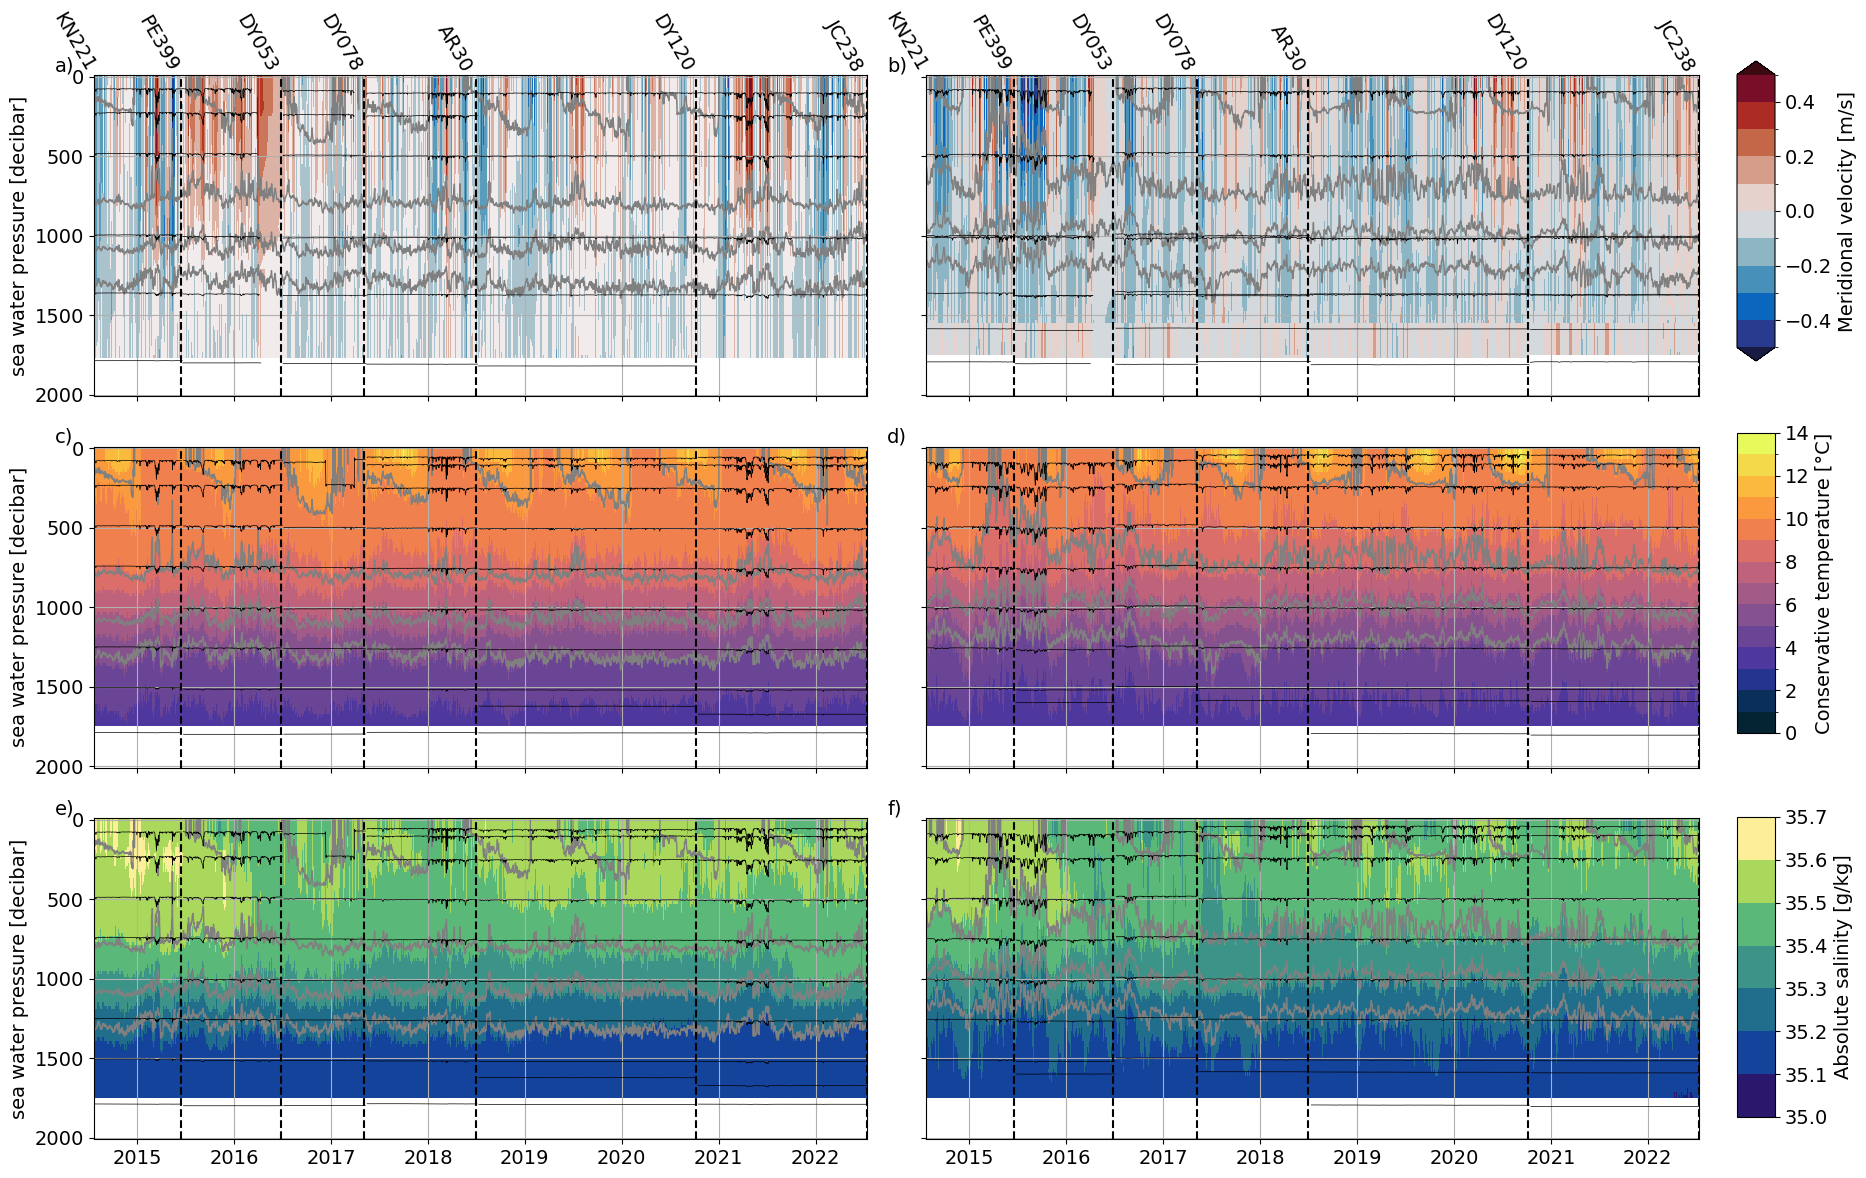

In [15]:
fig = rtv.plot_moorings_paper(ds_RT,ds_RT_stacked)
fig.savefig(f'{fig_out_path}RT_EB_WB_gridded_timeseries_{date_str_start[:-2]}_{date_str_end[:-2]}.png',dpi=300,bbox_inches='tight')

In [16]:
f'{fig_out_path}RT_EB_WB_gridded_timeseries_{date_str_start[:-2]}_{date_str_end[:-2]}.png'

'C:/Users/sa07kb/Projects/Rockall_Trough_Transports/figures/9.0_Paper_Rockall_Trough_Results/RT_EB_WB_gridded_timeseries_2014_2022.png'

# Rockall Trough Mean Sections

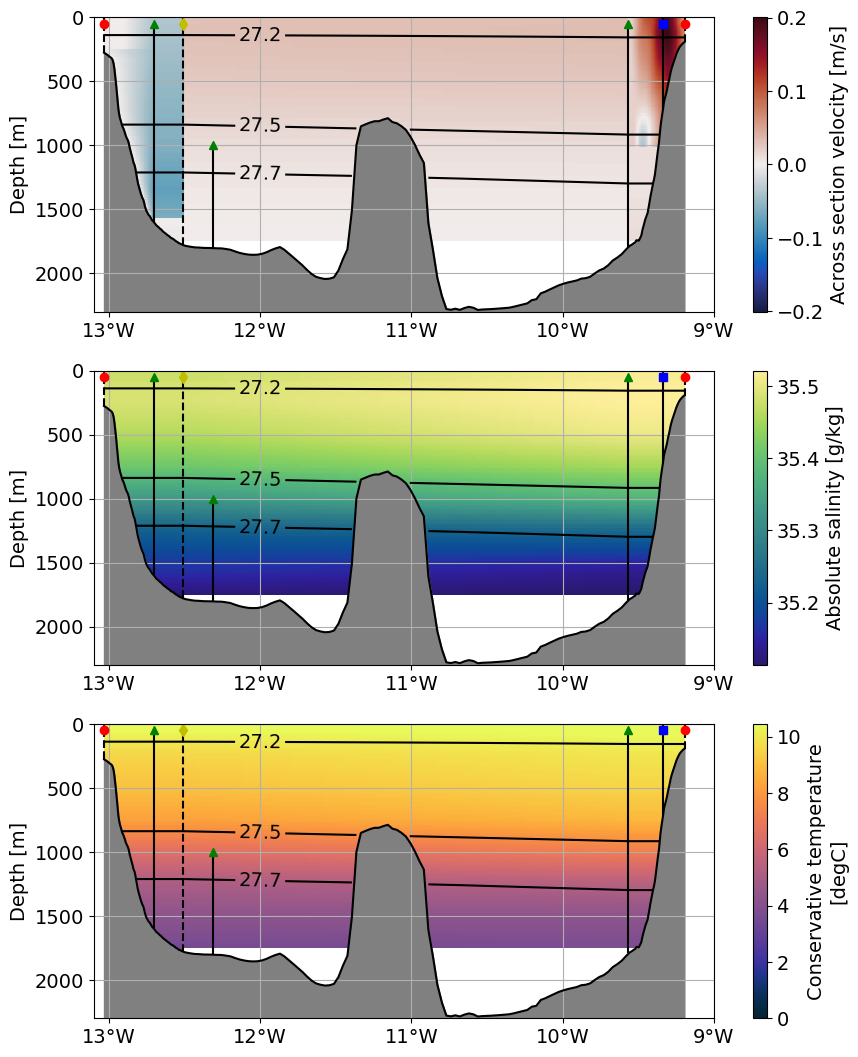

In [17]:
## figure
fig = rtv.plot_RT_mean_sections_from_mooring(ds_q_RT,ds_RT_loc)
# fig.savefig(f'{fig_out_path}Rockall_Trough_mean_sections_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## EW, WW and glider

In [18]:
fs=18
font = {'weight' : 'normal',
        'size'   : fs}
plt.rc('font', **font)

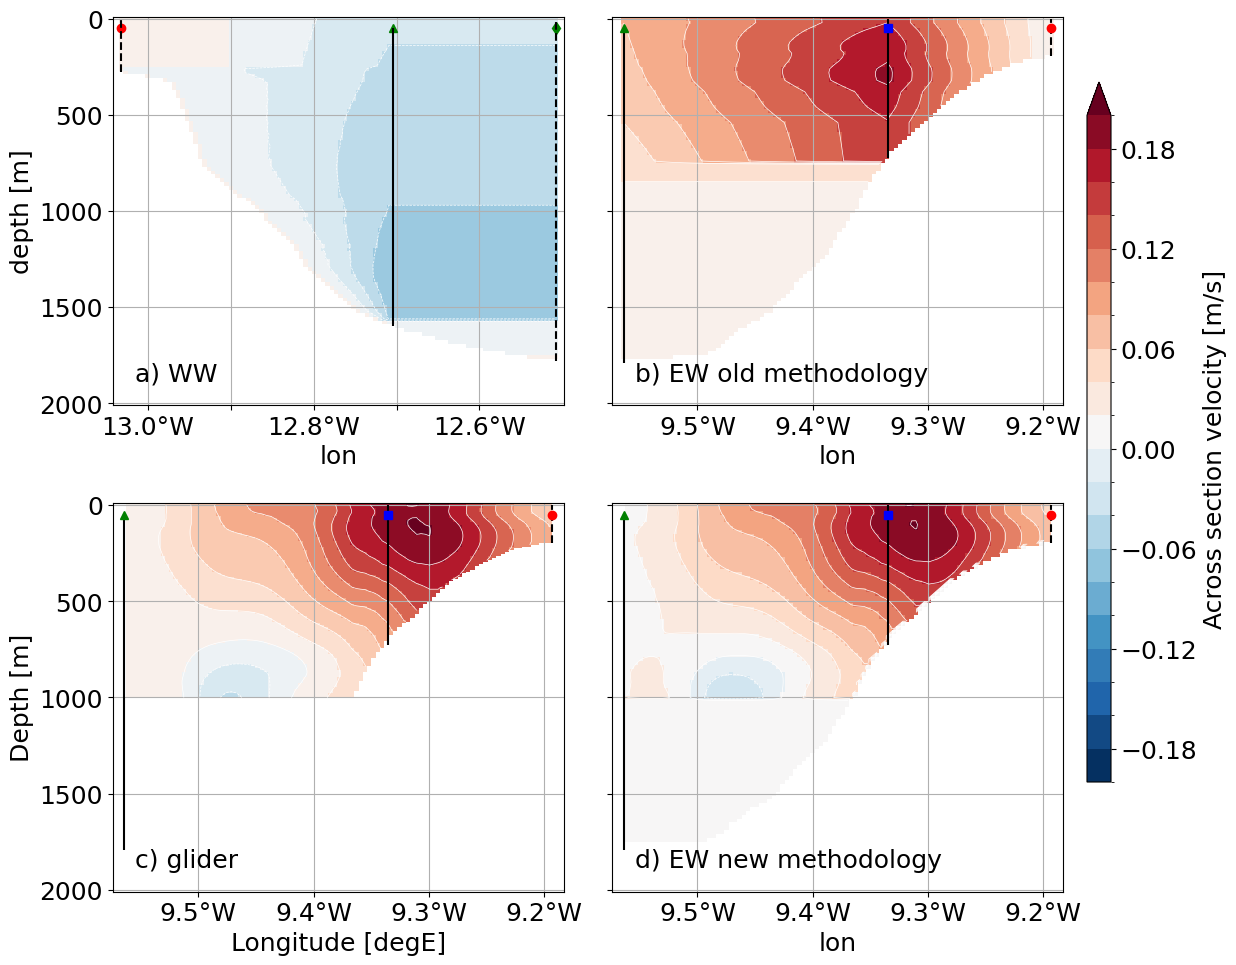

In [19]:
v_glider = ds_glider.vcur
v_glider['depth']=abs(v_glider.depth)

v_old=ds_q_RTEW_F22.v

xticks_WW = np.arange(-13.,ds_RT_loc.lon_RTWB,.1)
xticklabels_WW = ['13.0°W',' ','12.8°W',' ','12.6°W']

xticks_EW = np.arange(-9.5,ds_RT_loc.lon_RTES,.1)
xticklabels_EW = ['9.5°W','9.4°W','9.3°W','9.2°W']

d= 50.

fig,axs = plt.subplots(2,2,figsize=[12,10],sharey=True)

vmin,vmax,levs=-0.2,0.2,21

ax = axs[0,0]
v = ds_q_RT.v.sel(lon=ds_q_RTWW.lon).mean('time')
v.depth['long_name']='Depth'
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.plot([ds_RT_loc.lon_RTWS],[d],'or')
ax.plot([ds_RT_loc.lon_RTWB],[d],'dg')
ax.plot([ds_RT_loc.lon_RTWB1],[d],'^g')

ax.vlines(ds_RT_loc.lon_RTWB,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWB,method='nearest'), 0,colors='k',ls='--')
ax.vlines(ds_RT_loc.lon_RTWS,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWS,method='nearest'), 0,colors='k',ls='--')
ax.vlines(ds_RT_loc.lon_RTWB1,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWB1,method='nearest'), 50,colors='k')

ax.set_xlim([ds_RT_loc.lon_RTWS-0.01,ds_RT_loc.lon_RTWB+0.01])
ax.set_xticks(xticks_WW)
ax.set_xticklabels(xticklabels_WW,fontsize=fs)

ax.text(0.05, 0.05,f'a) WW',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[0,1]
v = v_old.mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)

ax.text(0.05, 0.05,f'b) EW old methodology',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[1,0]
v = v_glider.mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.text(0.05, 0.05,f'c) glider',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[1,1]
v = ds_q_RT.v.sel(lon=ds_q_RTEW.lon).mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.text(0.05, 0.05,f'd) EW new methodology',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

for i,ax in enumerate(axs.flat):
    ax.grid()
    if i>0:
        ax.vlines(ds_RT_loc.lon_RTADCP,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTADCP,method='nearest'), 0,colors='k')
        ax.vlines(ds_RT_loc.lon_RTEB,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTEB,method='nearest'), 50,colors='k')
        ax.vlines(ds_RT_loc.lon_RTES,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTES,method='nearest'), 0,colors='k',ls='--')
        
        ax.plot([ds_RT_loc.lon_RTES],[d],'or')
        ax.plot([ds_RT_loc.lon_RTADCP],[d],'sb')
        ax.plot([ds_RT_loc.lon_RTEB],[d],'^g')
        
        ax.set_xlim([ds_RT_loc.lon_RTEB-0.01,ds_RT_loc.lon_RTES+0.01])
        ax.set_xticks(xticks_EW)
        ax.set_xticklabels(xticklabels_EW,fontsize=fs)
        
    if i==1 or i==3:
        ax.set_ylabel('')
plt.tight_layout()
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.7])
cb =fig.colorbar(im_hdl, cax=cbar_ax)
cb.set_label('Across section velocity [m/s]')

fig.savefig(f'{fig_out_path}Rockall_Trough_WW_EW_glider_mean_section_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

# EW moored vs glider reconstructed transports

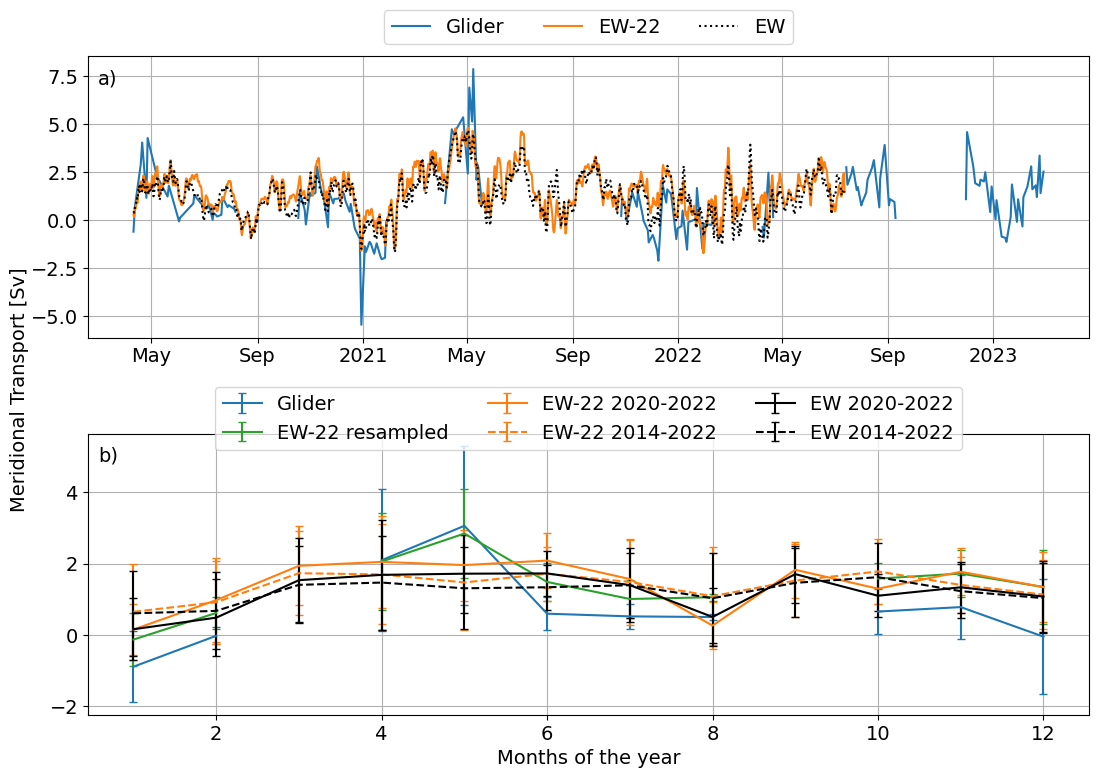

In [75]:
fig,axs = plt.subplots(2,1,figsize = [11,8])
q_moored = ds_q_RTEW_F22.q.sel(depth=slice(None,1000) ,time=slice(ds_glider.time.min().values,ds_glider.time.max().values)
                ).sum(['lon','depth'])/1e6
q_moored_new = ds_q_RT.q.sel(lon=ds_q_RTEW.lon,depth=slice(None,1000) ,time=slice(ds_glider.time.min().values,ds_glider.time.max().values)
                ).sum(['lon','depth'])/1e6

## subplot 1
ax = axs[0]
color='C0'
ds_glider_nan.Q.plot.line('-',ax=ax,label='Glider',color=color)
color='C1'
q_moored.plot.line('-',ax=ax,label='EW-22',color=color)
color='k'
q_moored_new.plot.line(':',ax=ax,label='EW',color=color)
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend(ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.2))
ax.grid()

# # suplot 2
# # select depth averaged meridional velocities
x_m = q_moored
x_n = q_moored_new
x_g = ds_glider_nan.Q
x_m = x_m.sel(time=slice(x_g.time.min().values,x_m.time.max().values))
x_n = x_n.sel(time=slice(x_g.time.min().values,x_m.time.max().values))
x_g = x_g.sel(time=slice(x_g.time.min().values,x_m.time.max().values))

ax = axs[1]
color='C0'
m=x_g.groupby('time.month').mean(['time'])
d=x_g.groupby('time.month').std('time')
dummy = m.notnull()
ax.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='Glider')

color='C2'
m = x_m.interp(time=x_g.time.values
                ).groupby('time.month').mean(['time'])
d=x_m.interp(time=x_g.time.values
                ).groupby('time.month').std('time')
ax.errorbar(m.where(dummy).month, m.where(dummy), yerr=d.where(dummy), 
            fmt='-', capsize=3, capthick=1, color=color,
            label='EW-22 resampled')

color='C1'
m = x_m.groupby('time.month').mean(['time'])
d=x_m.groupby('time.month').std('time')
ax.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='EW-22 2020-2022')

color='C1'
m1 = ds_q_RTEW_F22.q.sel(depth=slice(None,1000)).sum(['lon','depth'])/1e6
m = m1.groupby('time.month').mean(['time'])
d = m1.groupby('time.month').std('time')
ax.errorbar(m.month, m, yerr=d, fmt='--', capsize=3, capthick=1, color=color,label='EW-22 2014-2022')

color='k'
m = x_n.groupby('time.month').mean(['time'])
d=x_n.groupby('time.month').std('time')
ax.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='EW 2020-2022')

color='k'
m1 = ds_q_RT.q.sel(lon=ds_q_RTEW.lon,depth=slice(None,1000)).sum(['lon','depth'])/1e6
m = m1.groupby('time.month').mean(['time'])
d= m1.groupby('time.month').std('time')
ax.errorbar(m.month, m, yerr=d, fmt='--', capsize=3, capthick=1, color=color,label='EW 2014-2022')

ax.set_xlabel('Months of the year')
ax.legend(ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.2))
ax.grid()



import string
fig.text(0.0, 0.5, 'Meridional Transport [Sv]', va='center', rotation='vertical');
for n, ax in enumerate(axs): 
    ax.text(0.01, 0.9, f'{string.ascii_lowercase[n]})', transform=ax.transAxes, )

plt.tight_layout()

t_start = str(ds_glider.time.min().dt.strftime("%Y%m%d").values)
t_end = str(ds_glider.time.max().dt.strftime("%Y%m%d").values)
fig.savefig((f'{fig_out_path}Rockall_Trough_V_moor_vs_glider_time_series_{t_start}_{t_end}.png'),
            dpi=300,bbox_inches='tight')
fig.savefig((f'{fig_out_path_od}Rockall_Trough_V_moor_vs_glider_time_series_{t_start}_{t_end}.png'),
            dpi=300,bbox_inches='tight')

In [21]:
t_glider=(ds_glider.Q.sel(time=slice(q_moored_new.time.min().values,q_moored_new.time.max().values)))
t_EW_F22=(q_moored.interp_like(ds_glider))
t_EW=(q_moored_new.interp_like(ds_glider))

display(t_EW_F22.mean('time').values)
display(t_EW.mean('time').values)
display(t_glider.mean('time').values)

display(t_EW_F22.where(t_EW_F22>0).mean('time').values)
display(t_EW.where(t_EW>0).mean('time').values)
display(t_glider.where(t_glider>0).mean('time').values)

display(t_EW_F22.where(t_EW_F22<0).mean('time').values)
display(t_EW.where(t_EW<0).mean('time').values)
display(t_glider.where(t_glider<0).mean('time').values)

array(1.41266631)

array(1.14516453)

array(0.76159291)

array(1.67641878)

array(1.54631057)

array(1.54993907)

array(-0.65677609)

array(-0.55058919)

array(-1.04034118)

In [22]:
display(1.41-0.76)
display(1.41-1.15)
display(1.15-0.76)
## 0.76
# 0.53
# 0.28
# 0.25

0.6499999999999999

0.26

0.3899999999999999

In [23]:
display((t_EW_F22.sel(time=slice(None,'2020-11')).mean('time').values
         +t_EW_F22.sel(time=slice('2021-2',None)).mean('time').values)/2
       )
display((t_EW.sel(time=slice(None,'2020-11')).mean('time').values
         +t_EW.sel(time=slice('2021-2',None)).mean('time').values)/2
       )
display((t_glider.sel(time=slice(None,'2020-11')).mean('time').values
         +t_glider.sel(time=slice('2021-2',None)).mean('time').values)/2
       )

1.617848775964398

1.3364000257064161

1.0901825856291836

In [24]:
display(1.62-1.09)
display(1.62-1.34)
display(1.34-1.09)
# 1.09

0.53

0.28

0.25

In [25]:
# interpolate moored data on glider data
x_m = q_moored-q_moored.mean('time')
x_g = ds_glider.Q-ds_glider.Q.mean('time')
x_m = x_m.sel(time=slice(x_g.time.min().values,x_m.time.max().values))
x_g = x_g.sel(time=slice(x_g.time.min().values,x_m.time.max().values))

x_m = x_m.interp_like(x_g)

# correlation
pearson_coef, _ = scipy.stats.pearsonr(x_m.where(x_m.notnull(),drop=True), x_g.where(x_m.notnull(),drop=True))
print("Pearson correlation coefficient:", pearson_coef)

spearman_coef, _ = scipy.stats.spearmanr(x_m.where(x_m.notnull(),drop=True), x_g.where(x_m.notnull(),drop=True))
print("Spearman correlation coefficient:", spearman_coef)

kendall_coef, _ = scipy.stats.kendalltau(x_m.where(x_m.notnull(),drop=True), x_g.where(x_m.notnull(),drop=True))
print("Kendall correlation coefficient:", kendall_coef)

Pearson correlation coefficient: 0.799626265201804
Spearman correlation coefficient: 0.7804308372129726
Kendall correlation coefficient: 0.6076277650648361


In [26]:
# interpolate moored data on glider data
x_m = q_moored_new-q_moored_new.mean('time')
x_g = ds_glider.Q-ds_glider.Q.mean('time')
x_m = x_m.sel(time=slice(x_g.time.min().values,x_m.time.max().values))
x_g = x_g.sel(time=slice(x_g.time.min().values,x_m.time.max().values))

x_m = x_m.interp_like(x_g)

# correlation
pearson_coef, _ = scipy.stats.pearsonr(x_m.where(x_m.notnull(),drop=True), x_g.where(x_m.notnull(),drop=True))
print("Pearson correlation coefficient:", pearson_coef)

spearman_coef, _ = scipy.stats.spearmanr(x_m.where(x_m.notnull(),drop=True), x_g.where(x_m.notnull(),drop=True))
print("Spearman correlation coefficient:", spearman_coef)

kendall_coef, _ = scipy.stats.kendalltau(x_m.where(x_m.notnull(),drop=True), x_g.where(x_m.notnull(),drop=True))
print("Kendall correlation coefficient:", kendall_coef)

Pearson correlation coefficient: 0.8138947868965817
Spearman correlation coefficient: 0.787548331097609
Kendall correlation coefficient: 0.6076277650648361


# Transport time series

In [27]:
fs=14
font = {'weight' : 'normal',
        'size'   : fs}
plt.rc('font', **font)

## Rockall Trough Volume Transport

In [64]:
RT_Q_Qh_Qf.Q_EW

<xarray.DataArray 'Q_EW' (TIME: 5827)> Size: 47kB
array([-1.274267, -1.405502, -1.465333, ...,  1.953175,  1.891666,  1.747219])
Coordinates:
  * TIME     (TIME) datetime64[ns] 47kB 2014-07-21T12:00:00 ... 2022-07-12T12...
Attributes:
    name:         RT_Q_EW
    long_name:    RT EW Volume Transport
    units:        Sv
    description:  Volume transport at eastern wedge of Rockall Trough derived...

In [66]:
print(RT_Q_Qh_Qf.Q_EW.sel(TIME=slice(None,'2015-03')).mean('TIME').values)
print(RT_Q_Qh_Qf.Q_EW.sel(TIME='2015').mean('TIME').values)

0.7008044371913574
1.858456193980194


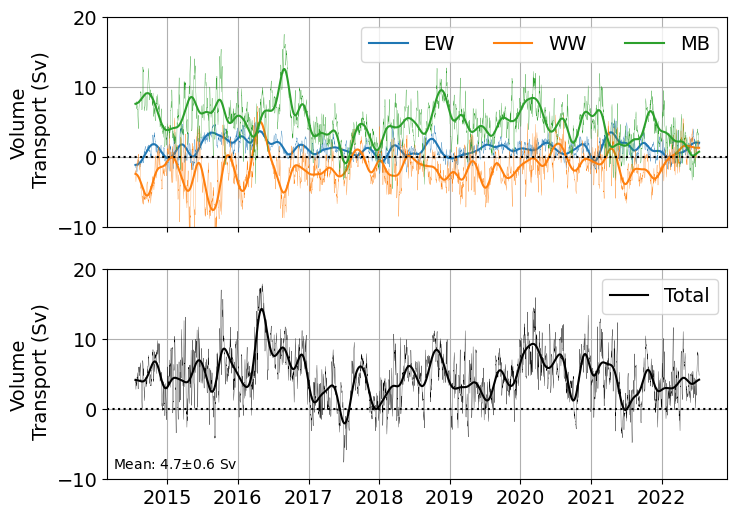

In [28]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Q_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Q_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Q_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Q_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Q_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Q_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[0])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-10, 20])
    ax.axhline(0,color='k',ls=':')

fig.savefig(f'{fig_out_path}Rockall_Trough_volume_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

In [29]:
def print_means(ds,var,var_se):
    print('%2.1f$\pm$%2.1f Sv, STD %2.1f Sv' %(
        ds[var].mean().values,ds[var_se].values,ds[var].std().values))

print('2014-2022 Total transport:')
print_means(RT_Q_Qh_Qf,'Q_tot','SE_tot') 

print('MB transport:')
print_means(RT_Q_Qh_Qf,'Q_MB','SE_MB') 

print('EW transport:')
print_means(RT_Q_Qh_Qf,'Q_EW','SE_EW') 

print('WW transport:')
print_means(RT_Q_Qh_Qf,'Q_WW','SE_WW') 

2014-2022 Total transport:
4.7$\pm$0.6 Sv, STD 3.6 Sv
MB transport:
5.0$\pm$0.5 Sv, STD 3.1 Sv
EW transport:
1.3$\pm$0.2 Sv, STD 1.3 Sv
WW transport:
-1.5$\pm$0.3 Sv, STD 2.7 Sv


In [30]:
t1,t2=None,'2020-10'

print(f'2014 to {t2} Total transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_tot','SE_tot') 

print(f'2014 to {t2} MB transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_MB','SE_MB') 

print(f'2014 to {t2} EW transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_EW','SE_EW') 

print(f'2014 to {t2} WW transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_WW','SE_WW') 

2014 to 2020-10 Total transport:
4.9$\pm$0.6 Sv, STD 3.7 Sv
2014 to 2020-10 MB transport:
5.4$\pm$0.5 Sv, STD 3.1 Sv
2014 to 2020-10 EW transport:
1.3$\pm$0.2 Sv, STD 1.3 Sv
2014 to 2020-10 WW transport:
-1.7$\pm$0.3 Sv, STD 2.8 Sv


In [31]:
t1,t2=None,'2018-07'

print(f'2014 to {t2} Total transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_tot','SE_tot') 

print(f'2014 to {t2} MB transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_MB','SE_MB') 

print(f'2014 to {t2} EW transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_EW','SE_EW') 

print(f'2014 to {t2} WW transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_WW','SE_WW') 

2014 to 2018-07 Total transport:
4.8$\pm$0.6 Sv, STD 3.9 Sv
2014 to 2018-07 MB transport:
5.3$\pm$0.5 Sv, STD 3.4 Sv
2014 to 2018-07 EW transport:
1.3$\pm$0.2 Sv, STD 1.4 Sv
2014 to 2018-07 WW transport:
-1.9$\pm$0.3 Sv, STD 3.0 Sv


## Rockall Trough Heat Transport

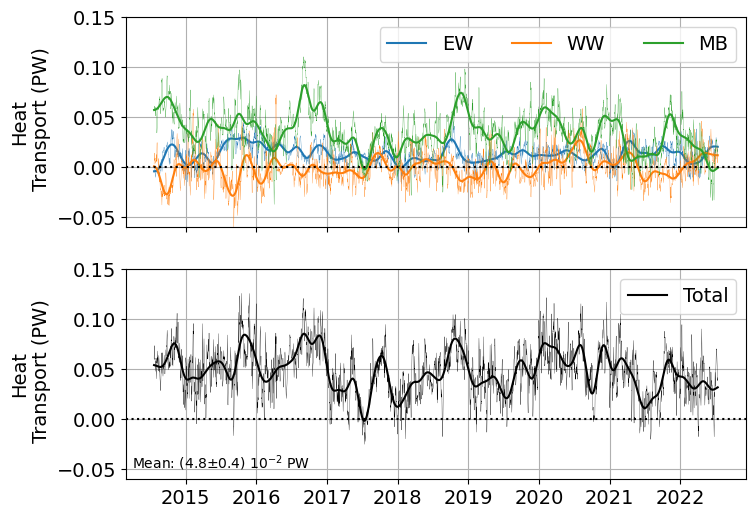

In [32]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Qh_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qh_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qh_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qh_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qh_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qh_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qh_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[1])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .15])
    ax.axhline(0,color='k',ls=':')

# fig.savefig(f'{fig_out_path}Rockall_Trough_heat_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Freshwater Transport

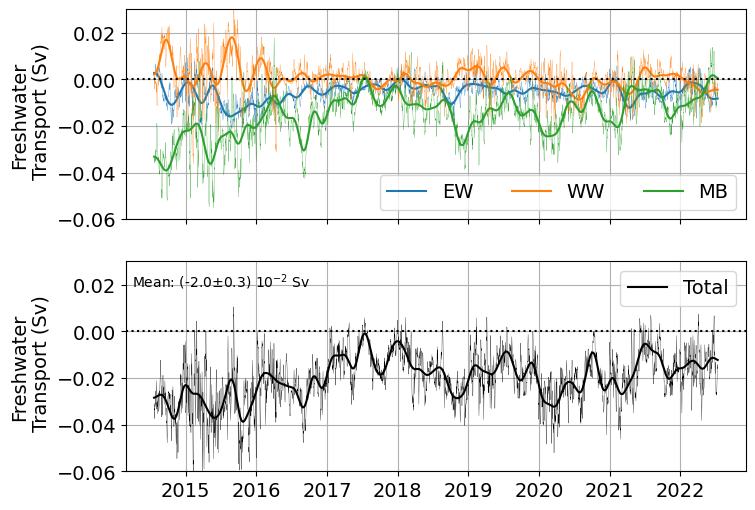

In [33]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .95

ax=axs[0]
RT_Q_Qh_Qf.Qf_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qf_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qf_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qf_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qf_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qf_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qf_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom,('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,va='top',
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[2])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .03])
    ax.axhline(0,color='k',ls=':')

# fig.savefig(f'{fig_out_path}Rockall_Trough_freshwater_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

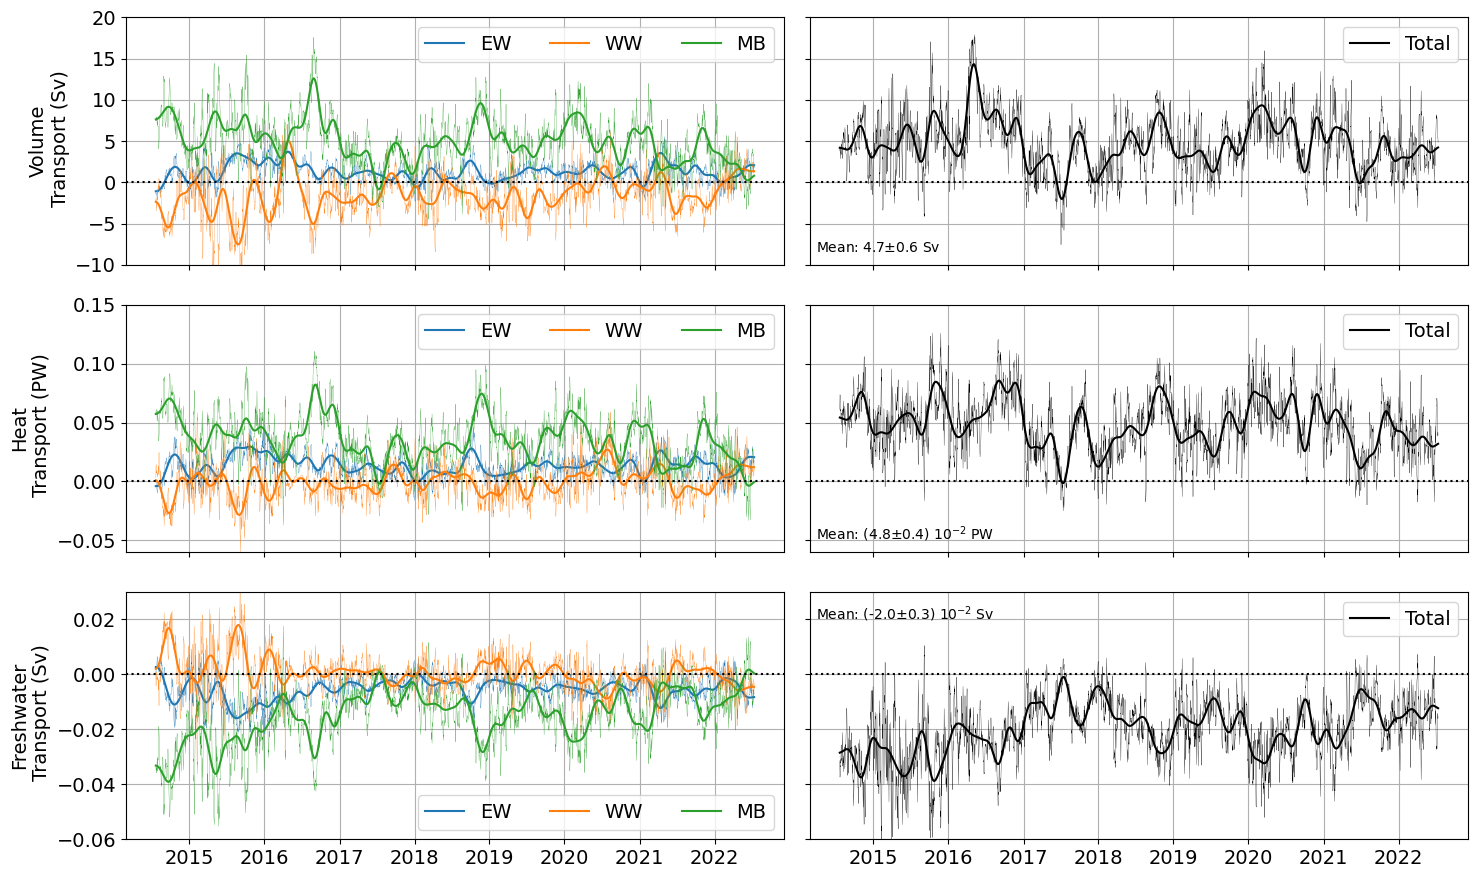

In [51]:
fig,axs = plt.subplots(3,2,sharex=True,figsize=[15,9])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

### volume
ax=axs[0,0]
RT_Q_Qh_Qf.Q_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Q_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Q_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Q_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Q_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Q_MB_lp.plot.line(ax=ax,color='C2',label='MB')

ax.set_ylim([-10, 20])
ax.set_ylabel(ylabel_name[0])

ax=axs[0,1]
RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=ax.transAxes)
ax.set_ylim([-10, 20])
ax.set_ylabel('')
ax.set_yticklabels('')

### heat
ax=axs[1,0]
RT_Q_Qh_Qf.Qh_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qh_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qh_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qh_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qh_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qh_MB_lp.plot.line(ax=ax,color='C2',label='MB')
ax.set_ylim([-.06, .15])
ax.set_ylabel(ylabel_name[1])

ax=axs[1,1]
left = .01
bottom = .05
RT_Q_Qh_Qf.Qh_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=ax.transAxes)
ax.set_ylim([-.06, .15])
ax.set_ylabel('')
ax.set_yticklabels('')

### freshwater
ax=axs[2,0]
RT_Q_Qh_Qf.Qf_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qf_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qf_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qf_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qf_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qf_MB_lp.plot.line(ax=ax,color='C2',label='MB')

ax.set_ylim([-.06, .03])
ax.set_ylabel(ylabel_name[2])

ax=axs[2,1]
left = .01
bottom = .95
RT_Q_Qh_Qf.Qf_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom,('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,va='top',
        transform=ax.transAxes)

ax.set_ylim([-.06, .03])
ax.set_ylabel('')
ax.set_yticklabels('')

### general
for i,ax in enumerate(axs.flat):
    ax.grid()
    ax.set_title('')
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.axhline(0,color='k',ls=':')
plt.tight_layout()

fig.savefig(f'{fig_out_path}Rockall_Trough_volume_heat_fw_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')
fig.savefig(f'{fig_out_path_od}/Rockall_Trough_volume_heat_fw_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## RT z-integrated transports

In [53]:
def calc_fluxes(ds,sec_str):
    #calculations
    qh = rtp.rhoCp*ds.q*(ds.CT - rtp.CT_ref)
    qf = -1*ds.q*(ds.SA - rtp.SA_ref)/rtp.SA_ref
    qS = ds.q*ds.SA/rtp.rho0 
     
    #attributes
    q_attrs={'name':f'q',
            'long_name':f'Volume transport per grid cell',
            'units':'Sv',
            'description':f'Volume transport per grid cell for RT {sec_str}'}
    qh_attrs={'name':f'qh',
            'long_name':f'Heat transport per grid cell',
            'units':'PW',
            'description':f'Heat transport per grid cell referenced '\
            f'to temperature of {rtp.CT_ref}degC for RT {sec_str}'}
    qf_attrs = {'name': f'qf',
                'long_name': f'Freshwater transport per grid cell',
                'units':'Sv',
                'description':f'Freshwater transport per grid cell referenced '\
                f'to salinity of {rtp.SA_ref} g/kg for RT {sec_str}'}
    qS_attrs = {'name': f'qS',
                'long_name': f'Salt transport per grid cell',
                'units':'Sv',
                'description':f'Salt transport per grid cell referenced '\
                f'to density time specific heat capacity of of {rtp.rho0}kg m^-3'\
                f'for RT {sec_str}'}
    
    ds.q.attrs =q_attrs
    qh.attrs =qh_attrs
    qf.attrs =qf_attrs
    qS.attrs =qS_attrs
    
    ds_q = xr.merge([ds.q.rename(ds.q.attrs['name']),
                     qh.rename(qh.attrs['name']),
                     qf.rename(qf.attrs['name']),
                     qS.rename(qS.attrs['name'])])
    
    ds_q.attrs = {'description':f'Volume, heat, freshwater and salt tranport'\
                    f' per grid cell for {sec_str} of Rockall Trough'}
    
    return ds_q

In [54]:
# Compute fluxes in each cell

ds_q_RTMB = calc_fluxes(ds_q_RTMB,'MB')
ds_q_RTWW = calc_fluxes(ds_q_RTWW,'WW')
ds_q_RTEW = calc_fluxes(ds_q_RTEW,'EW')


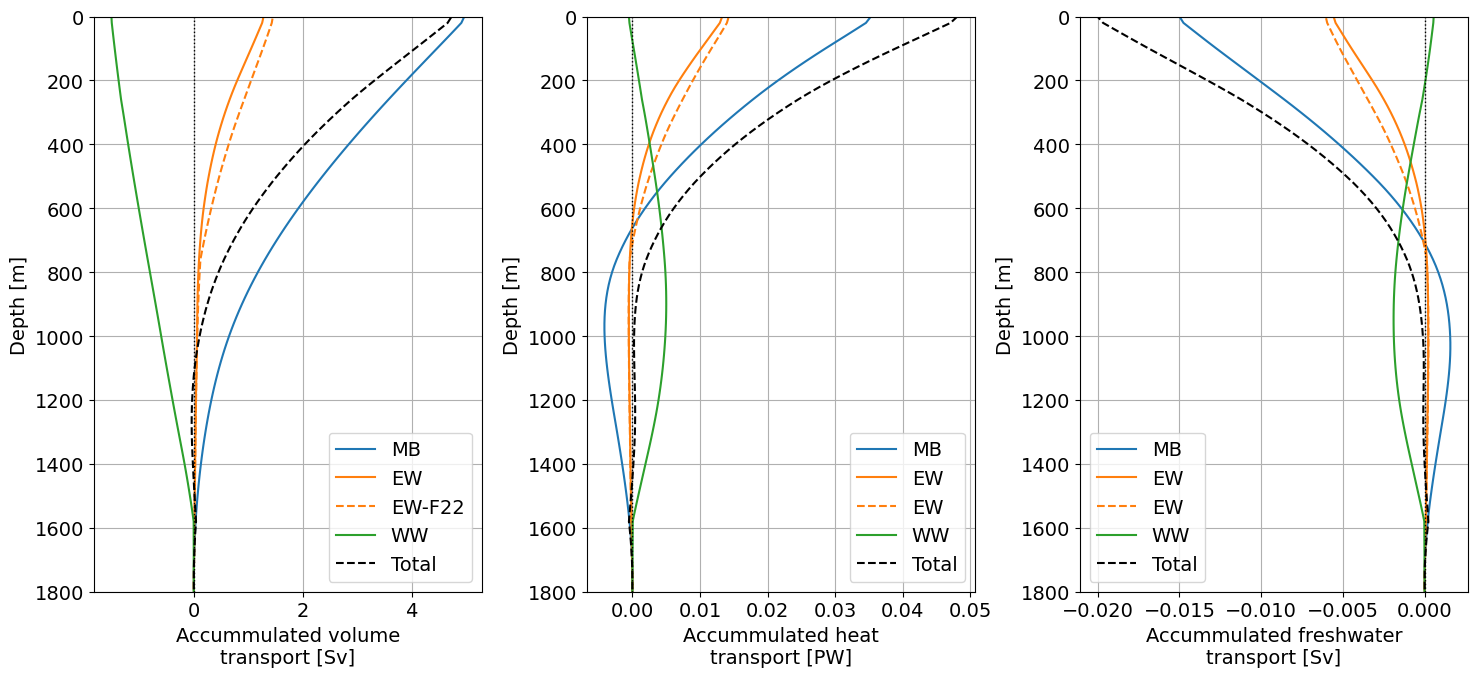

In [55]:
fig,axs = plt.subplots(1,3,figsize=[15,7])
ax=axs[0]
(ds_q_RTMB.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax,color='C0')
(ds_q_RTEW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax,color='C1')
(ds_q_RTEW_F22.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTEW_F22.depth[::-1]).cumsum('depth').plot.line('--',y='depth',label='EW-F22',ax=ax,color='C1')
(ds_q_RTWW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax,color='C2')
(ds_q_RT.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RT.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated volume\ntransport [Sv]')

ax=axs[1]
(ds_q_RTMB.qh.sum('lon')/1e15).mean(['time']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax,color='C0')
(ds_q_RTEW.qh.sum('lon')/1e15).mean(['time']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax,color='C1')
(ds_q_RTEW_F22.qh.sum('lon')/1e15).mean(['time']).reindex(depth=ds_q_RTEW_F22.depth[::-1]).cumsum('depth').plot.line('--',y='depth',label='EW',ax=ax,color='C1')
(ds_q_RTWW.qh.sum('lon')/1e15).mean(['time']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax,color='C2')
total = ((ds_q_RTMB.qh.sum('lon')+ds_q_RTEW.qh.sum('lon')+(ds_q_RTWW.qh.sum('lon')))/1e15)
total.mean(['time']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated heat\ntransport [PW]')

ax=axs[2]
(ds_q_RTMB.qf.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax,color='C0')
(ds_q_RTEW.qf.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax,color='C1')
(ds_q_RTEW_F22.qf.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTEW_F22.depth[::-1]).cumsum('depth').plot.line('--',y='depth',label='EW',ax=ax,color='C1')
(ds_q_RTWW.qf.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax,color='C2')
total = ((ds_q_RTMB.qf.sum('lon')+ds_q_RTEW.qf.sum('lon')+(ds_q_RTWW.qf.sum('lon')))/1e6)
total.mean(['time']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated freshwater\ntransport [Sv]')


for ax in axs:
    ax.axvline(0,ls=':',color='k',lw='1')
    ax.legend()
    ax.set_ylabel('Depth [m]')
    ax.grid()
    ax.set_title('')
plt.tight_layout()

fig.savefig(f'{fig_out_path}Rockall_Trough_depth_accumulated_mean_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')
fig.savefig(f'{fig_out_path_od}/Rockall_Trough_depth_accumulated_mean_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

In [56]:
fig_out_path_od

WindowsPath('C:/Users/sa07kb/OneDrive - SAMS/RT_tansports_2014_2022/figures')